# SGEMM GPU kernel performance


This data set measures the running time of a matrix-matrix product A*B = C, where all matrices have size 2048 x 2048, using a parameterizable SGEMM GPU kernel with 261400 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds
      
Attribute Information:<br>
Independent variables:
**MWG, NWG:** per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)<br>
3 **KWG:** inner dimension of 2D tiling at workgroup level: {16, 32} (integer)<br>
4-5 **MDIMC, NDIMC:** local workgroup size: {8, 16, 32} (integer)<br>
6-7 **MDIMA, NDIMB:** local memory shape: {8, 16, 32} (integer)<br>
8 **KWI:** kernel loop unrolling factor: {2, 8} (integer)<br>
9-10 **VWM, VWN:** per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)<br>
11-12 **STRM, STRN**: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)<br>
13-14 **SA, SB**: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)<br>

Output:<br>
15-18 **Run1, Run2, Run3, Run4:** performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08.   

Preprocessing:<br>
Compute the mean of the four Output columns in one column "Run"

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

import sys
sys.path.insert(1, '../RegressionAlgorithms/')
from knn import *
import linearRegressionNumpy

### Get the Data

In [2]:
data = pd.read_csv('sgemm_product.csv', delimiter = ',', engine='python')

In [3]:
data

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.96,17.77,17.77,17.77
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.04,36.03,36.04,36.03
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.28,34.82,35.27,35.27
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.43,28.49,28.44,28.45


### Basic Data Information 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241600 entries, 0 to 241599
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   MWG        241600 non-null  int64  
 1   NWG        241600 non-null  int64  
 2   KWG        241600 non-null  int64  
 3   MDIMC      241600 non-null  int64  
 4   NDIMC      241600 non-null  int64  
 5   MDIMA      241600 non-null  int64  
 6   NDIMB      241600 non-null  int64  
 7   KWI        241600 non-null  int64  
 8   VWM        241600 non-null  int64  
 9   VWN        241600 non-null  int64  
 10  STRM       241600 non-null  int64  
 11  STRN       241600 non-null  int64  
 12  SA         241600 non-null  int64  
 13  SB         241600 non-null  int64  
 14  Run1 (ms)  241600 non-null  float64
 15  Run2 (ms)  241600 non-null  float64
 16  Run3 (ms)  241600 non-null  float64
 17  Run4 (ms)  241600 non-null  float64
dtypes: float64(4), int64(14)
memory usage: 33.2 MB


In [5]:
data.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,25.513113,13.935894,13.935894,17.371126,17.371126,5.000000,2.448609,2.448609,0.500000,0.500000,0.500000,0.500000,217.647852,217.579536,217.532756,217.527669
std,42.469220,42.469220,7.855619,7.873662,7.873662,9.389418,9.389418,3.000006,1.953759,1.953759,0.500001,0.500001,0.500001,0.500001,369.012422,368.677309,368.655118,368.677413
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.290000,13.250000,13.360000,13.370000
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.660000,40.710000,40.660000,40.640000
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,5.000000,2.000000,2.000000,0.500000,0.500000,0.500000,0.500000,69.825000,69.930000,69.790000,69.820000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,228.530000,228.310000,228.320000,228.320000
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3339.630000,3375.420000,3397.080000,3361.710000


*Check for missing values*

In [6]:
print(data.isnull().sum(axis=0))

MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
KWI          0
VWM          0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
Run3 (ms)    0
Run4 (ms)    0
dtype: int64


*Merge the Runs Columns*

In [7]:
df = pd.DataFrame(data,columns=['Run1 (ms)','Run2 (ms)','Run3 (ms)', 'Run4 (ms)'])
av_row = df.mean(axis=1)

data.drop(columns=['Run1 (ms)','Run2 (ms)','Run3 (ms)', 'Run4 (ms)'])
data['Run'] = av_row

data

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),Run
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81,118.6625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.96,17.77,17.77,17.77,17.8175
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.04,36.03,36.04,36.03,36.0350
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.28,34.82,35.27,35.27,35.1600
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.43,28.49,28.44,28.45,28.4525


### Exploratory Data Analysis

**Run Count**

*Histogram of Run Count Distribution*

Text(0.5, 0, 'Run Count')

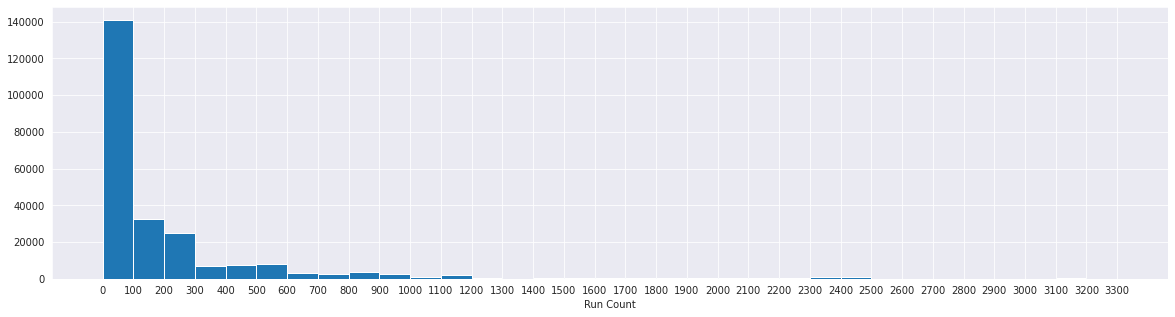

In [8]:
fig = plt.figure(figsize = (20,5))
sns.set_style('darkgrid')
bins = np.arange(0, 3400, 100).tolist()
data['Run'].hist(bins=bins)
plt.xticks(bins)
plt.xlabel('Run Count')

**Run Time vs MWG & NWG**

*Box Plot Run Time vs MWG & NWG*

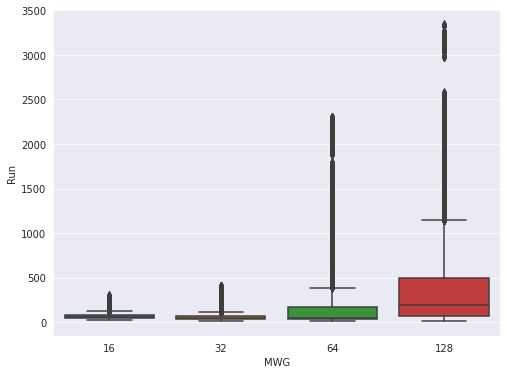

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['MWG'], y=data['Run'])
plt.show()

**Run Time vs KWG**

*Box Plot on Run Time vs KWG*

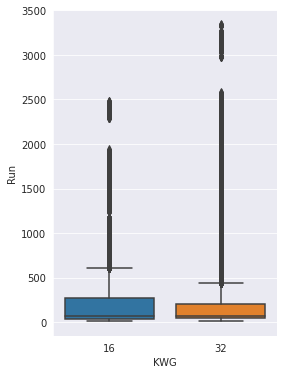

In [10]:
plt.figure(figsize=(4, 6))
sns.boxplot(x=data['KWG'], y=data['Run'])
plt.show()

**Run Time vs MDIMC & NDIMC**

*Box Plot on Run Time vs MDIMC & NDIMC*

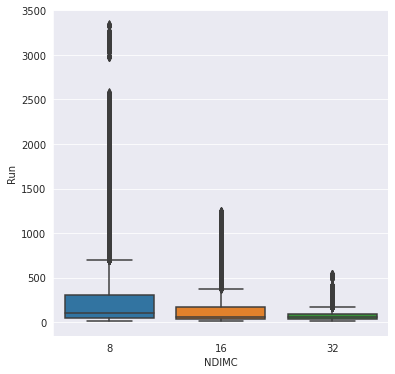

In [11]:
plt.figure(figsize=(6, 6))
sns.boxplot(x=data['NDIMC'], y=data['Run'])
plt.show()

**Run Time vs MDIMA & NDIMA**

*Box Plot on Run Time vs MDIMA & NDIMA*

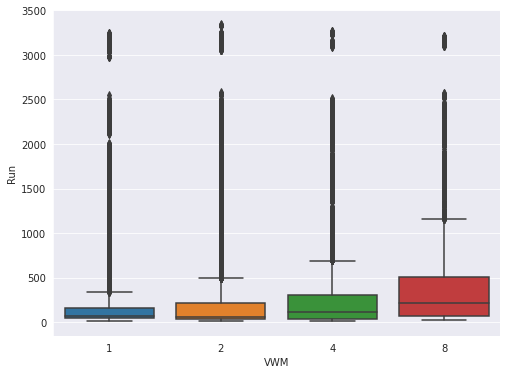

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['VWM'], y=data['Run'])
plt.show()

**Run Time vs KWI**

*Box Plot on Run Time vs KWI*

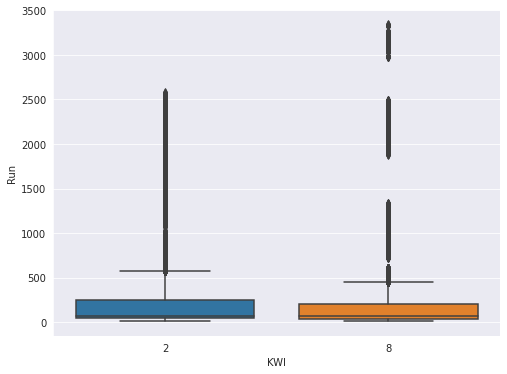

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['KWI'], y=data['Run'])
plt.show()

**Run Time vs VWM & VWNN**

*Box Plot on Run Time vs VWM & VWN*

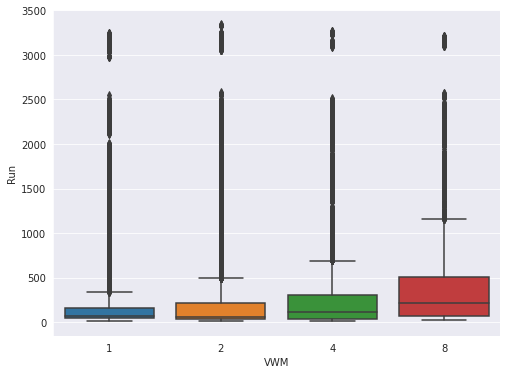

In [14]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['VWM'], y=data['Run'])
plt.show()

**Run Time vs STRM & STRN**

*Box Plot on Run Time vs STRM & STRN*

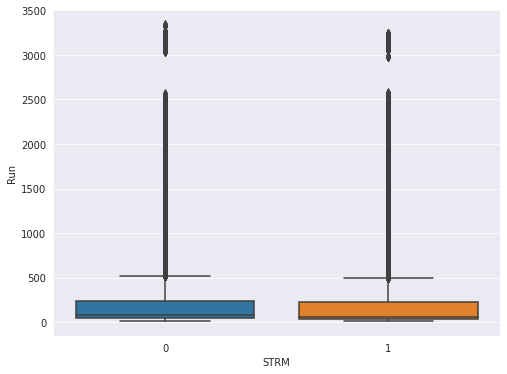

In [15]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['STRM'], y=data['Run'])
plt.show()

**Run Time vs SA & SB**

*Box Plot on Run Time vs SA & SB*

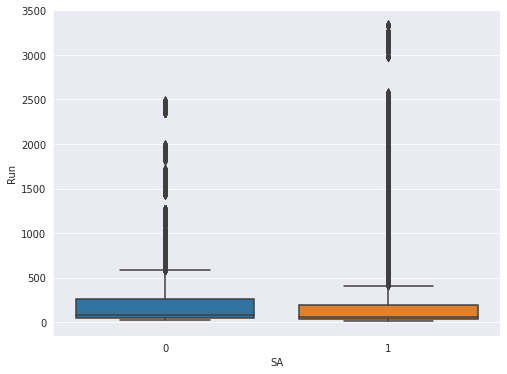

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['SA'], y=data['Run'])
plt.show()

## Preprocessing

*We don't have nominal value. No Encoding needed*

**Data preparation**

In [17]:
X = data.drop('Run', axis=1)
y = data['Run']

*Training and Test Split*

In [18]:
#split the data in attributes and class as well as training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Regression Tasks

*Regression Algorithms from Sklearn*

### Linear Regression

In [19]:
model = linear_model.LinearRegression().fit(X_train, y_train)

# Make predictions using the testing set
y_pred1 = model.predict(X_test)

# The coefficients
print('Coefficients: \n', model.coef_, model.intercept_)

Coefficients: 
 [ 7.91693561e-16 -1.16573418e-15 -9.41874660e-16  5.08706866e-15
  1.26084691e-15  1.94312185e-16 -2.69031429e-16  1.43675515e-15
  5.99061496e-16 -2.73721281e-16 -2.08481496e-15  1.14810170e-15
  9.73851519e-15  4.13043812e-15  2.50000000e-01  2.50000000e-01
  2.50000000e-01  2.50000000e-01] -1.1368683772161603e-13


**Evaluation metrics**

In [20]:
print('cross validation score: ', cross_val_score(model, X_test, y_pred1, cv=10))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred1))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred1))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))

cross validation score:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Coefficient of determination: 1.00
Mean Absolute Error: 7.827393381479817e-14
Mean Squared Error: 1.2960440437120288e-26
Root Mean Squared Error: 1.1384393017249663e-13


### KNN Regression

In [21]:
model = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

**Evaluation metrics**

In [22]:
print('cross validation score: ', cross_val_score(model, X_test, y_pred, cv=10))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

cross validation score:  [0.99998384 0.99998061 0.99998358 0.99998252 0.99998332 0.99998096
 0.99998231 0.99998037 0.99998226 0.99998346]
Coefficient of determination: 1.00
Mean Absolute Error: 0.6574667379506994
Mean Squared Error: 0.9498990508588586
Root Mean Squared Error: 0.9746276472883676


### Decision Tree Regression

In [23]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state = 0).fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

**Evaluation metrics**

In [24]:
print('cross validation score: ', cross_val_score(model, X_test, y_pred, cv=10))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

KeyboardInterrupt: 

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor().fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

**Evaluation metrics**

In [ ]:
print('cross validation score: ', cross_val_score(model, X_test, y_pred, cv=10))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
data.info()

*Our Regression Algorithms*

### Linear Regression Function (MSE)

In [ ]:
try:
    del X_train['bias']
except:
    print('no bias to remove X_train')    
try:
    del X_test['bias']
except:
    print('no bias to remove X_test')
try:
    del X['bias']
except:
    print('no bias to remove X')




print('\n GPU: Linear Regression Function (MSE):')    
alphaMethod = 'const'
mu = 1
convCritList = [1e5, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2]
print('epsilon       | sum total error:   | sum relative error:  | iterations | Rsquare |    time/s')
for convergenceCriterion in convCritList:
    start = time.time()
    weights, score, iterations = linearRegressionNumpy.linearRegression(X_train, y_train, mu = mu, 
                                                        convergenceCriterion = convergenceCriterion, lossFunction = 'MSE', 
                                                        alphaMethod = alphaMethod, printOutput = False)
    end = time.time()
    yPred2 = linearRegressionNumpy.predictLinearRegression(X_test, weights)



    print('{:13.0E} | {:19}| {:21}| {:11}| {:8.4f}| {:10.5f}'.format(convergenceCriterion, 
                                        str(np.sum(yPred2-y_pred1)), 
                                        str(np.sum((yPred2-y_pred1)/y_pred1)),
                                        str(iterations),
                                        r2_score(y_test, yPred2),
                                        end-start))
    
print('\nFinal weigths for smallest epsilon = {:2.0E}:'.format(convCritList[-1]))
print('weights = ', weights, '\n')

plt.title('GPUPerformance: scikit prediction')
plt.plot(y_pred1)
plt.ylabel('performance time (ms)')
plt.savefig('GPUPerformance_scikit_prediction_MSE.jpeg', bbox_inches='tight')
plt.show()

plt.title('GPUPerformance: our prediction (MSE)')
plt.plot(yPred2)
plt.ylabel('performance time (ms)')
plt.savefig('GPUPerformance_our_prediction_MSE.jpeg', bbox_inches='tight')
plt.show()

plt.title('GPUPerformance: our prediction (MSE) vs. scikit prediction')
plt.plot(yPred2-y_pred1)
plt.ylabel('total error')
plt.savefig('GPUPerformance_total_error_MSE.jpeg', bbox_inches='tight')
plt.show()

plt.title('GPUPerformance: our prediction (MSE) vs. scikit prediction')
plt.plot((yPred2-y_pred1)/y_pred1)
plt.ylabel('relative error')
plt.savefig('GPUPerformance_relative_error_MSE.jpeg', bbox_inches='tight')
plt.show()


no bias to remove X_train
no bias to remove X_test
no bias to remove X

 GPU: Linear Regression Function (MSE):
epsilon       | sum total error:   | sum relative error:  | iterations | Rsquare |    time/s
        1E+05 | -11445401.001420427| -84672.36391673831   | 2          |  -0.2844|   12.61806
        1E+04 | -11445401.001420427| -84672.36391673831   | 2          |  -0.2844|   10.63664
        1E+03 | 260073.75523709928 | -970.040174529866    | 21         |   0.9180|   15.88507
        1E+02 | 34965.9541752853   | 10721.688557111276   | 37         |   0.9488|   21.07517
        1E+01 | -69795.07277114081 | -2910.472534340723   | 124        |   0.9982|   54.19700
        1E+00 | 20867.83032629869  | 787.8906206180443    | 182        |   0.9993|   98.47044
        1E-01 | -4643.581453979787 | -185.32159340004674  | 240        |   0.9995|   98.28804


**Evaluation metrics**

In [ ]:
print('\n GPU: Linear Regression Function (MSE):')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' %r2_score(y_test, yPred2))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, yPred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, yPred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, yPred2)))

### Linear Regression Function (MAE)

In [ ]:
try:
    del X_train['bias']
except:
    print('no bias to remove X_train')    
try:
    del X_test['bias']
except:
    print('no bias to remove X_test')
try:
    del X['bias']
except:
    print('no bias to remove X')


print('\n GPU: Linear Regression Function (MAE):')   
alphaMethod = 'const'
mu = 1
convCritList = [1e5, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]
print('epsilon       | sum total error:   | sum relative error:  | iterations | Rsquare |    time/s')
for convergenceCriterion in convCritList:
    start = time.time()
    weights, score, iterations = linearRegressionNumpy.linearRegression(X_train, y_train, mu = mu, 
                                                        convergenceCriterion = convergenceCriterion, lossFunction = 'MAE', 
                                                        alphaMethod = alphaMethod, printOutput = False)
    end = time.time()
    yPred2 = linearRegressionNumpy.predictLinearRegression(X_test, weights)



    print('{:13.0E} | {:19}| {:21}| {:11}| {:8.4f}| {:10.5f}'.format(convergenceCriterion, 
                                        str(np.sum(yPred2-y_pred1)), 
                                        str(np.sum((yPred2-y_pred1)/y_pred1)),
                                        str(iterations),
                                        r2_score(y_test, yPred2),
                                        end-start))

print('\nFinal weigths for smallest epsilon = {:2.0E}:'.format(convCritList[-1]))
print('weights = ', weights, '\n')

plt.title('GPUPerformance: scikit prediction')
plt.plot(y_pred1)
plt.ylabel('performance time (ms)')
plt.savefig('GPUPerformance_scikit_prediction_MAE.jpeg', bbox_inches='tight')
plt.show()

plt.title('GPUPerformance: our prediction (MAE)')
plt.plot(yPred2)
plt.ylabel('performance time (ms)')
plt.savefig('GPUPerformance_our_prediction_(MAE.jpeg', bbox_inches='tight')
plt.show()

plt.title('GPUPerformance: our prediction ((MAE) vs. scikit prediction')
plt.plot(yPred2-y_pred1)
plt.ylabel('total error')
plt.savefig('GPUPerformance_total_error_(MAE.jpeg', bbox_inches='tight')
plt.show()

plt.title('GPUPerformance: our prediction ((MAE) vs. scikit prediction')
plt.plot((yPred2-y_pred1)/y_pred1)
plt.ylabel('relative error')
plt.savefig('GPUPerformance_relative_error_(MAE.jpeg', bbox_inches='tight')
plt.show()


**Evaluation metrics**

In [ ]:
print('\n GPU: Linear Regression Function (MAE):')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, yPred2))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, yPred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, yPred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, yPred2)))

### Linear Regression Function (RMSE)

In [ ]:
try:
    del X_train['bias']
except:
    print('no bias to remove X_train')    
try:
    del X_test['bias']
except:
    print('no bias to remove X_test')
try:
    del X['bias']
except:
    print('no bias to remove X')


print('\n GPU: Linear Regression Function (RMSE):')
alphaMethod = 'const'
mu = 1
convCritList = [1e5]#, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]#, 1e-5]
print('epsilon       | sum total error:   | sum relative error:  | iterations | Rsquare |    time/s')
for convergenceCriterion in convCritList:
    start = time.time()
    weights, score, iterations = linearRegressionNumpy.linearRegression(X_train, y_train, mu = mu, 
                                                        convergenceCriterion = convergenceCriterion, lossFunction = 'RMSE', 
                                                        alphaMethod = alphaMethod, printOutput = False)
    end = time.time()
    yPred2 = linearRegressionNumpy.predictLinearRegression(X_test, weights)



    print('{:13.0E} | {:19}| {:21}| {:11}| {:8.4f}| {:10.5f}'.format(convergenceCriterion, 
                                        str(np.sum(yPred2-y_pred1)), 
                                        str(np.sum((yPred2-y_pred1)/y_pred1)),
                                        str(iterations),
                                        r2_score(y_test, yPred2),
                                        end-start))

print('\nFinal weigths for smallest epsilon = {:2.0E}:'.format(convCritList[-1]))
print('weights = ', weights, '\n')

plt.title('GPUPerformance: scikit prediction')
plt.plot(y_pred1)
plt.ylabel('performance time(ms)')
plt.savefig('GPUPerformance_scikit_prediction_RMSE.jpeg', bbox_inches='tight')
plt.show()

plt.title('SeoulBikeSharing: our prediction (RMSE)')
plt.plot(yPred2)
plt.ylabel('performance time (ms)')
plt.savefig('GPUPerformance_our_prediction_RMSE.jpeg', bbox_inches='tight')
plt.show()

plt.title('GPUPerformance: our prediction (RMSE) vs. scikit prediction')
plt.plot(yPred2-y_pred1)
plt.ylabel('total error')
plt.savefig('GPUPerformance_total_error_RMSE.jpeg', bbox_inches='tight')
plt.show()

plt.title('GPUPerformance: our prediction (RMSE) vs. scikit prediction')
plt.plot((yPred2-y_pred1)/y_pred1)
plt.ylabel('relative error')
plt.savefig('GPUPerformance_relative_error_RMSE.jpeg', bbox_inches='tight')
plt.show()


**Evaluation metrics**

In [ ]:
print('\n GPU: Linear Regression Function (RMSE):')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, yPred2))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, yPred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, yPred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, yPred2)))

### KNN

**Dictionary creation to apply the mathematical functions of the algorithm**

In [ ]:
dictionary = data.to_dict('records')

In [ ]:
dictionary

In [ ]:
len(dictionary)

**Forecasting instances**

In [ ]:
y_test

**Algorithm parameters**

In [ ]:
mode = 1 # 1 = KNeighbors; 2 = RadiusNeighbors
n_neighbours = 5
distance_function = 1 # 1 = Euclidean Distance; 2 = Manhattan Distance
radius = 0 # 0 indicates no radius
label = 'Run'
features = ['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)']

**Algorithm initialization**

In [ ]:
knn = KNN(dictionary, label, features, mode, n_neighbours, distance_function, radius)

**Execution of the algorithm (forecasting)**

In [ ]:
results = []

for x in y_test.index:
    #print(x)
    target = dictionary[x-1]
    #print(target)
    result = knn.run(target)
    #print(result)
    results.append(result)

**Predictions**

In [ ]:
predictions = pd.Series(results,index=y_test.index)

In [ ]:
predictions

**Evaluation metrics**

In [ ]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, predictions))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))